In [ ]:
pip install emukit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 KB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emukit: filename=emukit-0.4.10-py3-none-any.whl size=257071 sha256=805a51e56b27f7afa1f7bd98cdcc57438c5a9d1e86d1257c4671f991799d0960
  Stored in directory: /root/.cache/pip/wheels/9d/87/f4/54faeaf90597394334ce816052e3e827fc014090a64d0af806
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102564 sha256=4fc4087ae28e601de

In [ ]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

In [ ]:
pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssDNS.csv') 
#RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssRANS.csv') 
DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssdns_short.csv') 
RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Linewssfullrans_short.csv') 


Mounted at /content/drive


In [ ]:
# Generate sample data

x_train_l =  np.array([[70,100],[70,80],[70,50],[70,30],[70,0],[60,100],[60,80],[60,50],[60,30],[60,0],[50,100],[50,80],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,30],[40,0]])
x_train_h = np.array([[70,100],[70,0],[60,80],[50,50],[40,100],[40,0]])

DNS_full=DNS_data.dropna(axis=1)
DNS_full=DNS_full.values
DNS=DNS_full[:,[0,2,3,7,8,10]]

DNS_test=DNS_full[:,[1,4,5,6,9]]
RANS=RANS_data.dropna(axis=1)
RANS_full=RANS.values
# RANS_test=RANS_full[:,[2,8,9,11,18]]
RANS=RANS_full
#D_70_100=np.array(DNS_data['70_100'])
#D_70_100=D_70_100.reshape(-1,1)
#np.stack(())
#print(column_values.shape)

DNS_full=np.transpose(DNS_full)
y_train_h=np.transpose(DNS)
y_train_l=np.transpose(RANS)

In [ ]:
# x_train_l=np.c_[ x_train_l, np.zeros(len(x_train_l)) ]   
# x_train_h=np.c_[ x_train_h, np.ones(len(x_train_h)) ]   
# X_train=np.append(x_train_l,x_train_h,axis=0)
# 
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

Y_train=np.append(y_train_l,y_train_h,axis=0)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_h, x_train_l], [y_train_h, y_train_l])
print(X_train.shape)
print(Y_train.shape)

print(X_train)

(26, 3)
(26, 57)
[[ 70. 100.   0.]
 [ 70.   0.   0.]
 [ 60.  80.   0.]
 [ 50.  50.   0.]
 [ 40. 100.   0.]
 [ 40.   0.   0.]
 [ 70. 100.   1.]
 [ 70.  80.   1.]
 [ 70.  50.   1.]
 [ 70.  30.   1.]
 [ 70.   0.   1.]
 [ 60. 100.   1.]
 [ 60.  80.   1.]
 [ 60.  50.   1.]
 [ 60.  30.   1.]
 [ 60.   0.   1.]
 [ 50. 100.   1.]
 [ 50.  80.   1.]
 [ 50.  50.   1.]
 [ 50.  30.   1.]
 [ 50.   0.   1.]
 [ 40. 100.   1.]
 [ 40.  80.   1.]
 [ 40.  50.   1.]
 [ 40.  30.   1.]
 [ 40.   0.   1.]]


In [ ]:
## Create standard GP model using only high-fidelity data
x_train_DNS=x_train_h
y_train_DNS=y_train_h
kernelDNS = GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)
high_gp_model = GPy.models.GPRegression(x_train_DNS, y_train_DNS, kernelDNS)
high_gp_model.Gaussian_noise.fix(0)

## Fit the GP model

high_gp_model.optimize_restarts(500)


Optimization restart 1/500, f = 1220.1684898870692
Optimization restart 2/500, f = 1331.7972144183834
Optimization restart 3/500, f = 1331.797214418383
Optimization restart 4/500, f = 1331.797214418519
Optimization restart 5/500, f = 1331.797214418383
Optimization restart 6/500, f = 1331.7972144192945
Optimization restart 7/500, f = 1331.7972144183832
Optimization restart 8/500, f = 1331.7972144183832
Optimization restart 9/500, f = 1331.7972144199698
Optimization restart 10/500, f = 1331.7972144185796
Optimization restart 11/500, f = 1331.7972144183827
Optimization restart 12/500, f = 1331.7972144184437
Optimization restart 13/500, f = 1331.7972144183832
Optimization restart 14/500, f = 1331.7972144183852
Optimization restart 15/500, f = 1331.7972144218995
Optimization restart 16/500, f = 1331.7972144183839
Optimization restart 17/500, f = 1331.7972144185685
Optimization restart 18/500, f = 1331.797214418383
Optimization restart 19/500, f = 1331.7972144183848
Optimization restart 20/5

In [ ]:
## Create standard GP model using only low-fidelity data
x_train_RANS=x_train_l
y_train_RANS=y_train_l
kernelRANS = GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)
low_gp_model = GPy.models.GPRegression(x_train_RANS, y_train_RANS, kernelRANS)
low_gp_model.Gaussian_noise.fix(0)

## Fit the GP model

low_gp_model.optimize_restarts(500)

Optimization restart 1/500, f = 3332.720021146886
Optimization restart 2/500, f = 4243.6524053951225
Optimization restart 3/500, f = 4243.6524053952735
Optimization restart 4/500, f = 4243.65240539514
Optimization restart 5/500, f = 4243.6524053952835
Optimization restart 6/500, f = 4243.652405395123
Optimization restart 7/500, f = 4243.652405395543
Optimization restart 8/500, f = 4243.652405395131
Optimization restart 9/500, f = 3332.7200211432587
Optimization restart 10/500, f = 4243.652405395122
Optimization restart 11/500, f = 4243.652405395122
Optimization restart 12/500, f = 4243.652405395264
Optimization restart 13/500, f = 4243.652405395121
Optimization restart 14/500, f = 4243.6524053951325
Optimization restart 15/500, f = 4243.652405395127
Optimization restart 16/500, f = 4243.652405395924
Optimization restart 17/500, f = 4243.652405395128
Optimization restart 18/500, f = 4243.652405395121
Optimization restart 19/500, f = 4243.6524053951225
Optimization restart 20/500, f = 42

In [ ]:

kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001),GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)]

lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)

#gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=500)

## Fit the model
  
lin_mf_model.optimize()

 /usr/local/lib/python3.9/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/500, f = 3624.211314640562
Optimization restart 2/500, f = 4949.808313528525
Optimization restart 3/500, f = 4949.808313529463
Optimization restart 4/500, f = 4949.8083135313755
Optimization restart 5/500, f = 4949.808313530853
Optimization restart 6/500, f = 4949.808313530045
Optimization restart 7/500, f = 4949.808313504696
Optimization restart 8/500, f = 4949.808313529602
Optimization restart 9/500, f = 4949.7976490826695
Optimization restart 10/500, f = 4949.808313530402
Optimization restart 11/500, f = 4949.808313791564
Optimization restart 12/500, f = 4949.80831359488
Optimization restart 13/500, f = 4949.808313529605
Optimization restart 14/500, f = 4949.80831353025
Optimization restart 15/500, f = 4949.8083135544175
Optimization restart 16/500, f = 4949.8083135319175
Optimization restart 17/500, f = 4949.808313532789
Optimization restart 18/500, f = 4949.808313531106
Optimization restart 19/500, f = 4949.80831351395
Optimization restart 20/500, f = 4949.8

In [ ]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[70,50],[60,30],[60,0],[50,80],[40,30]])
X_plot_l=np.c_[ x_plot, np.ones(len(x_plot)) ]   
X_plot_h=np.c_[ x_plot, np.zeros(len(x_plot)) ]  

In [ ]:
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)

hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(X_plot_h)
lf_mean_low_gp_model, lf_var_low_gp_model  = low_gp_model.predict(X_plot_h)

In [ ]:
# print(np.amax(hf_mean_lin_mf_model))
print(np.sqrt(hf_var_lin_mf_model)*1.96)
print(np.sqrt(hf_var_high_gp_model)*1.96)
print(np.sqrt(lf_var_low_gp_model)*1.96)
# c=(hf_mean_lin_mf_model.shape)
# print(c)



[[2.09692357]
 [1.41139758]
 [1.15805891]
 [0.63855671]
 [1.19300756]]
[[3.83440658]
 [2.48763814]
 [1.2340839 ]
 [1.10648422]
 [1.27690688]]
[[0.000196]
 [0.000196]
 [0.000196]
 [0.000196]
 [0.000196]]


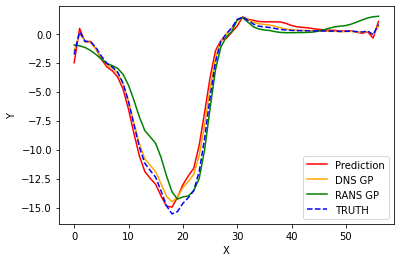

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
fig,ax=plt.subplots()
#DNS_test.shape[0]
i=3


#for i in range(1):
ax.plot(hf_mean_lin_mf_model[i],color='r',label='Prediction')
#ax.fill_between((hf_mean_lin_mf_model[0] - 1.96*hf_std_lin_mf_model[0]).flatten(), 
#(hf_mean_lin_mf_model[0] + 1.96*hf_std_lin_mf_model[0]).flatten(), color='r', alpha=0.3)
# ax.plot(RANS_test[:,i],color='k',linestyle='dotted',label='RANS')
ax.plot(hf_mean_high_gp_model[i],color='orange',label='DNS GP')
ax.plot(lf_mean_low_gp_model[i],color='green',label='RANS GP')
ax.plot(DNS_test[:,i],color='b',linestyle='--',label='TRUTH')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()


# np.savetxt('MF_70_e50_dns5_rans_8.dat', zip(write_mf), fmt=['%.3f','%.3f'])
# np.savetxt('LF_70_e50_dns5_rans_8.dat', zip(x_data,y_lf), fmt=['%.3f','%.3f'])
# np.savetxt('HF_70_e50_dns5_rans_8.dat', zip(x_data,y_hf), fmt=['%.3f','%.3f'])

In [ ]:
# CI = np.ones(c[1])*1.96*hf_std_lin_mf_model[i,:].reshape(-1,1)
# CI=CI.T
# print(CI.shape)
x_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/xshort_points.csv') 
y_data=hf_mean_lin_mf_model[i].reshape(-1,1)
y_hf=hf_mean_high_gp_model[i].reshape(-1,1)
y_lf=lf_mean_low_gp_model[i].reshape(-1,1)
print(y_data.shape)
print(x_data.shape)
write_mf = np.stack((x_data,y_data), axis = 1).reshape(-1,2)
write_lf = np.stack((x_data,y_lf), axis = 1).reshape(-1,2)
write_hf = np.stack((x_data,y_hf), axis = 1).reshape(-1,2)
print(write_hf.shape)

e= "streamwise WSS"
hdrtxt='# xpoints','#ypoints'
np.savetxt('/content/drive/MyDrive/ColabNotebooks/MF_50_e80_dns6_rans_20.dat', write_mf, delimiter='  ' )
np.savetxt('/content/drive/MyDrive/ColabNotebooks/LF_50_e80_dns6_rans_20.dat', write_lf, delimiter='   ' )
np.savetxt('/content/drive/MyDrive/ColabNotebooks/HF_50_e80_dns6_rans_20.dat', write_hf, delimiter='   ' )

(57, 1)
(57, 1)
(57, 2)


Text(0, 0.5, 'Y')

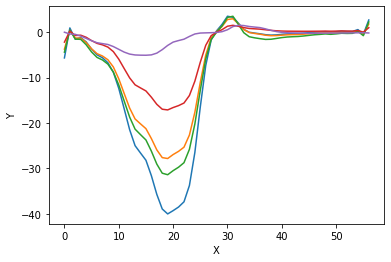

In [ ]:
fig,ax=plt.subplots()
for i in range(hf_mean_lin_mf_model.shape[0]):
   ax.plot(hf_mean_lin_mf_model[i])
ax.set_xlabel('X')
ax.set_ylabel('Y')


In [ ]:
i=4
y_true=DNS_test[:,i].reshape(-1,1)
# y_rans=RANS_test[:,i].reshape(-1,1)


write_truth = np.stack((x_data,y_true), axis = 1).reshape(-1,2)
# write_rans = np.stack((x_data,y_rans), axis = 1).reshape(-1,2)


np.savetxt('/content/drive/MyDrive/ColabNotebooks/Truth_40_e30.dat', write_truth, delimiter='  ' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/RANS_70_e50.dat', write_rans, delimiter='   ' )


In [ ]:
DNS_test=np.transpose(DNS_test)
fig,ax=plt.subplots()
for i in range(DNS_test.shape[1]):
   ax.plot(DNS_test[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot(hf_mean_lin_mf_model[2],color='r',linestyle='dotted',label='Prediction')


In [ ]:

fig,ax=plt.subplots()
for i in range(RANS_full.shape[1]):
   ax.plot(RANS_full[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [ ]:
  print(DNS_test[0])


In [ ]:
plt.figure(figsize=(12,8))
plt.ylabel('HF(x)')
plt.xlabel('LF(x)')

plt.plot(y_train_l[[0,2,4,7,8,10],:], y_train_h, color='purple',marker='*',)
plt.title('Mapping from low fidelity to high fidelity')
plt.legend(['HF-LF Correlation'], loc='lower center');